<a href="https://colab.research.google.com/github/IvanKoykov/-CV/blob/main/NIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SimpleITK
!pip install rarfile

     |████████████████████████████████| 48.4 MB 1.3 MB/s 


In [ ]:
!ls 

drive  MICCAI_BraTS2020_TrainingData  sample_data


In [ ]:
%rm -rf MICCAI_BraTS2020_TrainingData

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import zipfile
import rarfile
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import os
import math
import pandas as pd
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, merge, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:
zip_file='/content/drive/My Drive/Нир(Сегментация по МРТ)/MICCAI_BraTS_2018_Data_Training.zip'
rar_file='/content/drive/My Drive/Нир(Сегментация по МРТ)/MICCAI_BraTS2020_TrainingData.rar'

In [ ]:
z=zipfile.ZipFile(zip_file, 'r')
z.extractall()
#rarr=rarfile.RarFile(rar_file, 'r')
#rarr.extractall()

KeyboardInterrupt: ignored

In [ ]:
#K.set_image_dim_ordering("th")
K.set_image_data_format('channels_first')

img_size = 240      #original img size is 240*240
smooth = 0.005 
num_of_aug = 2
num_epoch = 30
pul_seq = 'Flair'
sharp = False       # sharpen filter
LR = 1e-4

num_of_patch = 4 #must be a square number
label_num = 5   # 1 = necrosis+NET, 2 = tumor core,3= original, 4 = ET, 5 = complete tumor
'''
0: other
1: necrosis + NET
2: edema
3: original
4: enhancing tumor
5: full tumor
'''

'\n0: other\n1: necrosis + NET\n2: edema\n3: original\n4: enhancing tumor\n5: full tumor\n'

In [ ]:
import glob

In [ ]:

def create_data(src, mask, label=False):
    files = glob.glob(src + mask, recursive=True)
    print(files)
    #r.seed(9)
    #r.shuffle(files)    # shuffle patients
    imgs = []
    print('Processing---', mask)
    for file in files:
        img = io.imread(file, plugin='simpleitk')
        #img = trans.resize(img, resize, mode='constant')
        if label:
            if label_num == 5:
                img[img != 0] = 1       #
            if label_num == 1:
                img[img != 1] = 0       #
            if label_num == 2:
                img[img == 2] = 0       
                img[img != 0] = 1       
            if label_num == 4:
                img[img != 4] = 0       #
                img[img == 4] = 1
            if label_num == 3:
                img[img == 3] = 1       
                
                
            img = img.astype('float32')
        else:
            img = (img-img.mean()) / img.std()      
            img = img.astype('float32')
        #print(img.shape)
        for slice in range(60,130):     
            img_t = img[slice,:,:]
            img_t =img_t.reshape((1,)+img_t.shape)
            img_t =img_t.reshape((1,)+img_t.shape) 
            for n in range(img_t.shape[0]):
                imgs.append(img_t[n,:,:,:])
    
    return np.array(imgs)

In [ ]:

def create_data_onesubject_val(src, mask,count, label=False):
    files = glob.glob(src + mask, recursive=True)
    #print(files)
    #r.seed(9)
    #r.shuffle(files)    # shuffle patients
    k = count
    #k=count
    print(k)

    imgs = []
    file = files[k]
    print('Processing---', mask,'--',file)
    
    img = io.imread(file, plugin='simpleitk')
    #img = trans.resize(img, resize, mode='constant')
    if label:
        if label_num == 5:
            img[img != 0] = 1       #
        if label_num == 1:
            img[img != 1] = 0       #
        if label_num == 2:
            img[img == 2] = 0       #
            img[img != 0] = 1       #
        if label_num == 4:
            img[img != 4] = 0       #
            img[img == 4] = 1
        img = img.astype('float32')
    else:
        img = (img-img.mean()) / img.std()      #
        img = img.astype('float32')
    for slice in range(155):     #
        img_t = img[slice,:,:]
        img_t =img_t.reshape((1,)+img_t.shape)
        img_t =img_t.reshape((1,)+img_t.shape)   #
     
        for n in range(img_t.shape[0]):
            imgs.append(img_t[n,:,:,:])
    
    return np.array(imgs)

In [ ]:
!ls '/content/drive/My Drive/Нир(Сегментация по МРТ)/MICCAI_BraTS2020_TrainingData.rar/'

In [ ]:
'''src='/content/MICCAI_BraTS2020_TrainingData/'
mask='BraTS20_Training_012/BraTS20_Training_012_flair.nii'
label=False
files = (src + mask)
print(files)
    #r.seed(9)
    #r.shuffle(files)    # shuffle patients
imgs = []
print('Processing---', mask)
img = io.imread(files, plugin='simpleitk')
        #img = trans.resize(img, resize, mode='constant')
if label:
            if label_num == 5:
                img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor
            if label_num == 1:
                img[img != 1] = 0       #only left necrosis and NET
            if label_num == 2:
                img[img == 2] = 0       #turn edema to 0
                img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core
            if label_num == 4:
                img[img != 4] = 0       #only left ET
                img[img == 4] = 1
            if label_num == 3:
                img[img == 3] = 1       # remain GT, design for 2015 data
                
                
            img = img.astype('float32')
else:
            img = (img-img.mean()) / img.std()      #normalization => zero mean   !!!care for the std=0 problem
            img = img.astype('float32')
        #print(img.shape)
for slice in range(60,130):     #choose the slice range
            img_t = img[slice,:,:]
            print(img_t.shape,'  0')
            img_t =img_t.reshape((1,)+img_t.shape)
            print(img_t.shape,'  1  ',img_t)
            img_t =img_t.reshape((1,)+img_t.shape) 
            print(img_t.shape,'  2  ',img_t)
            for n in range(img_t.shape[0]):
                imgs.append(img_t[n,:,:])
    
'/content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_031/BraTS20_Training_031_flair.nii'
'''

"src='/content/MICCAI_BraTS2020_TrainingData/'\nmask='BraTS20_Training_012/BraTS20_Training_012_flair.nii'\nlabel=False\nfiles = (src + mask)\nprint(files)\n    #r.seed(9)\n    #r.shuffle(files)    # shuffle patients\nimgs = []\nprint('Processing---', mask)\nimg = io.imread(files, plugin='simpleitk')\n        #img = trans.resize(img, resize, mode='constant')\nif label:\n            if label_num == 5:\n                img[img != 0] = 1       #Region 1 => 1+2+3+4 complete tumor\n            if label_num == 1:\n                img[img != 1] = 0       #only left necrosis and NET\n            if label_num == 2:\n                img[img == 2] = 0       #turn edema to 0\n                img[img != 0] = 1       #only keep necrosis, ET, NET = Tumor core\n            if label_num == 4:\n                img[img != 4] = 0       #only left ET\n                img[img == 4] = 1\n            if label_num == 3:\n                img[img == 3] = 1       # remain GT, design for 2015 data\n               

In [ ]:
np.array(imgs).shape

(70, 1, 240, 240)

In [ ]:

count = 100
pul_seq = 'flair'
Flair = create_data('/content/MICCAI_BraTS2020_TrainingData/', '**/*{}.nii'.format(pul_seq),  label=False)
#Flair = create_data_onesubject_val('MICCAI_BraTS2020_TrainingData/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
pul_seq = 't1ce'
#T1c = create_data('/content/MICCAI_BraTS2020_TrainingData/', '**/*{}.nii'.format(pul_seq),  label=False)
pul_seq = 't1'
#T1 = create_data('/content/MICCAI_BraTS2020_TrainingData/', '**/*{}.nii'.format(pul_seq),  label=False)
pul_seq = 't2'
T2 = create_data('/content/MICCAI_BraTS2020_TrainingData/', '**/*{}.nii'.format(pul_seq),  label=False)
label_num = 5
Label_full = create_data('/content/MICCAI_BraTS2020_TrainingData/', '**/*seg.nii',  label=True)
label_num = 2
#Label_core = create_data('/content/MICCAI_BraTS2020_TrainingData/', '**/*seg.nii',  label=True)
#label_num = 4
#Label_ET = create_data('/content/MICCAI_BraTS2020_TrainingData/', '**/*seg.nii',  label=True)
label_num = 3
#Label_all = create_data('/content/MICCAI_BraTS2020_TrainingData/', '**/*seg.nii', label=True)

[]
Processing--- **/*flair.nii
[]
Processing--- **/*t2.nii
[]
Processing--- **/*seg.nii


In [ ]:
Flair.shape

(2940, 1, 240, 240)

IndexError: ignored

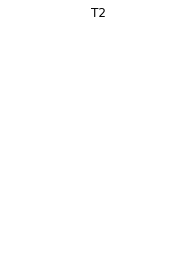

In [ ]:
plt.figure(figsize=(15,10))

'''plt.subplot(241)
plt.title('T1')
plt.axis('off')
plt.imshow(T1[30,0,:,:],cmap='gray')'''

plt.subplot(241)
plt.title('T2')
plt.axis('off')
plt.imshow(T2[90, 0, :, :],cmap='gray')
    
plt.subplot(242)
plt.title('Flair')
plt.axis('off')
plt.imshow(Flair[90,0, :, :],cmap='gray')

'''plt.subplot(244)
plt.title('T1c')
plt.axis('off')
plt.imshow(T1c[30,0, :, :],cmap='gray')'''

plt.subplot(243)
plt.title('Ground Truth(Full)')
plt.axis('off')
plt.imshow(Label_full[90, 0, :, :],cmap='gray')
'''
plt.subplot(246)
plt.title('Ground Truth(Core)')
plt.axis('off')
plt.imshow(Label_core[30, 0, :, :],cmap='gray')

plt.subplot(247)
plt.title('Ground Truth(ET)')
plt.axis('off')
plt.imshow(Label_ET[30, 0, :, :],cmap='gray')

plt.subplot(248)
plt.title('Ground Truth(All)')
plt.axis('off')
plt.imshow(Label_all[30, 0, :, :],cmap='gray')'''

plt.show()

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
 
def unet_model():
   
    inputs = Input(( 1,img_size, img_size))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (inputs)
    batch1 = BatchNormalization(axis=1)(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2)) (batch1)
  
    
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (pool1)
    batch2 = BatchNormalization(axis=1)(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2)) (batch2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (pool2)
    batch3 = BatchNormalization(axis=1)(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2)) (batch3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (pool3)
    batch4 = BatchNormalization(axis=1)(conv4)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2)) (batch4)
    
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (pool4)
    batch5 = BatchNormalization(axis=1)(conv5)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same') (batch5)
    batch5 = BatchNormalization(axis=1)(conv5)
    
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (batch5)
    up6 = concatenate([up6, conv4], axis=1)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (up6)
    batch6 = BatchNormalization(axis=1)(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same') (batch6)
    batch6 = BatchNormalization(axis=1)(conv6)
    
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (batch6)
    up7 = concatenate([up7, conv3], axis=1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (up7)
    batch7 = BatchNormalization(axis=1)(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same') (batch7)
    batch7 = BatchNormalization(axis=1)(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (batch7)
    up8 = concatenate([up8, conv2], axis=1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (up8)
    batch8 = BatchNormalization(axis=1)(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same') (batch8)
    batch8 = BatchNormalization(axis=1)(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (batch8)
    up9 = concatenate([up9, conv1], axis=1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (up9)
    batch9 = BatchNormalization(axis=1)(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same') (batch9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    model = Model(inputs=[inputs], outputs=[conv10])#Поменять параметр по умолчанию  data_format=MKL

    model.compile(optimizer=Adam(lr=LR), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [ ]:
def segnet():
  inp = Input((1,img_size, img_size))

  conv_1_1 = Conv2D(64, (3, 3), padding='same')(inp)
  conv_1_1 = Activation('relu')(conv_1_1)

  conv_1_2 = Conv2D(64, (3, 3), padding='same')(conv_1_1)
  conv_1_2 = Activation('relu')(conv_1_2)

  pool_1 = MaxPooling2D(2,2)(conv_1_2)


  conv_2_1 = Conv2D(128, (3, 3), padding='same')(pool_1)
  conv_2_1 = Activation('relu')(conv_2_1)

  conv_2_2 = Conv2D(128, (3, 3), padding='same')(conv_2_1)
  conv_2_2 = Activation('relu')(conv_2_2)

  pool_2 = MaxPooling2D(2,2)(conv_2_2)


  conv_3_1 = Conv2D(256, (3, 3), padding='same')(pool_2)
  conv_3_1 = Activation('relu')(conv_3_1)

  conv_3_2 = Conv2D(256, (3, 3), padding='same')(conv_3_1)
  conv_3_2 = Activation('relu')(conv_3_2)

  pool_3 = MaxPooling2D(2,2)(conv_3_2)


  conv_4_1 = Conv2D(512, (3, 3), padding='same')(pool_3)
  conv_4_1 = Activation('relu')(conv_4_1)

  conv_4_2 = Conv2D(512, (3, 3), padding='same')(conv_4_1)
  conv_4_2 = Activation('relu')(conv_4_2)

  pool_4 = MaxPooling2D(2,2)(conv_4_2)

  up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
  conv_up_1_1 = Conv2D(512, (3, 3), padding='same')(up_1)
  conv_up_1_1 = Activation('relu')(conv_up_1_1)

  conv_up_1_2 = Conv2D(512, (3, 3), padding='same')(conv_up_1_1)
  conv_up_1_2 = Activation('relu')(conv_up_1_2)


  up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
  conv_up_2_1 = Conv2D(256, (3, 3), padding='same')(up_2)
  conv_up_2_1 = Activation('relu')(conv_up_2_1)

  conv_up_2_2 = Conv2D(256, (3, 3), padding='same')(conv_up_2_1)
  conv_up_2_2 = Activation('relu')(conv_up_2_2)


  up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
  conv_up_3_1 = Conv2D(128, (3, 3), padding='same')(up_3)
  conv_up_3_1 = Activation('relu')(conv_up_3_1)

  conv_up_3_2 = Conv2D(128, (3, 3), padding='same')(conv_up_3_1)
  conv_up_3_2 = Activation('relu')(conv_up_3_2)



  up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
  conv_up_4_1 = Conv2D(64, (3, 3), padding='same')(up_4)
  conv_up_4_1 = Activation('relu')(conv_up_4_1)

  conv_up_4_2 = Conv2D(1, (1, 1), padding='same')(conv_up_4_1)
  result = Activation('sigmoid')(conv_up_4_2)


  model = Model(inputs=inp, outputs=result)
  model.compile(optimizer=Adam(lr=LR), loss=dice_coef_loss, metrics=[dice_coef])
  return model

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Flair.shape

(2660, 1, 240, 240)

In [ ]:
x = np.zeros((2940,2,240,240),np.float32)
x[:,:1,:,:] = Flair[:,:,:,:]   
x[:,1:,:,:] = T2[:,:,:,:]

In [ ]:
x = np.zeros((2940,1,240,240),np.float32)
x[:,:,:,:] = Flair[:,:,:,:] 

In [ ]:
x.shape

(2940, 1, 240, 240)

In [ ]:
X_train, X_test, Y_train, y_test = train_test_split(x, Label_full, test_size=0.1, random_state=42)

In [ ]:
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train,test_size=0.10,random_state=42)

In [ ]:
model = segnet()
#model=unet_model()
#model.load_weights('/content/drive/My Drive/Нир(Сегментация по МРТ)/wights_Flair_T2.h5')
#history = model.fit(x, y, batch_size=16, validation_split=0,validation_data = (val_x,val_y) ,epochs = 40,callbacks = callbacks_list ,verbose=1, shuffle=True)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
x_train.shape,x_val.shape

((2381, 2, 240, 240), (265, 2, 240, 240))

In [ ]:
history=model.fit(x_train, y_train, batch_size=16, validation_split=0,validation_data=(x_val,y_val) ,epochs = 40 ,verbose=1, shuffle=True)

Epoch 1/40
149/149 [==============================] - 74s 494ms/step - loss: 0.2109 - dice_coef: 0.7892 - val_loss: 0.1927 - val_dice_coef: 0.8086
Epoch 2/40
149/149 [==============================] - 73s 491ms/step - loss: 0.1804 - dice_coef: 0.8197 - val_loss: 0.2419 - val_dice_coef: 0.7597
Epoch 3/40
149/149 [==============================] - 76s 507ms/step - loss: 0.1695 - dice_coef: 0.8304 - val_loss: 0.1627 - val_dice_coef: 0.8386
Epoch 4/40
149/149 [==============================] - 76s 509ms/step - loss: 0.1520 - dice_coef: 0.8481 - val_loss: 0.1458 - val_dice_coef: 0.8554
Epoch 5/40
149/149 [==============================] - 73s 491ms/step - loss: 0.1409 - dice_coef: 0.8591 - val_loss: 0.1389 - val_dice_coef: 0.8624
Epoch 6/40
149/149 [==============================] - 73s 490ms/step - loss: 0.1379 - dice_coef: 0.8621 - val_loss: 0.1311 - val_dice_coef: 0.8702
Epoch 7/40
149/149 [==============================] - 73s 489ms/step - loss: 0.1338 - dice_coef: 0.8662 - val_loss: 0.

KeyboardInterrupt: ignored

In [ ]:
model.save_weights('/content/wights/wights_Flair_T2_SegNet.h5')

In [ ]:

#model.load_weights('/content/wights/wights_Flair_T2_SegNet.h5')
model.load_weights('/content/drive/MyDrive/Нир(Сегментация по МРТ)/wights_Flair_T2.h5')

ValueError: ignored

In [ ]:
label_num = 5
count=28
pul_seq='flair'
Pred_x = create_data_onesubject_val('/content/HGG/', '**/*{}.nii.gz'.format(pul_seq), count ,label=False)
pul_seq = 't2'
T2 = create_data_onesubject_val('/content/HGG/', '**/*{}.nii.gz'.format(pul_seq), count, label=False)
Pred_y = create_data_onesubject_val('/content/HGG/', '**/*seg.nii.gz', count, label=True)

28


IndexError: ignored

In [ ]:
label_num = 5
count=1
pul_seq='flair'
Pred_x = create_data_onesubject_val('/content/MICCAI_BraTS2020_TrainingData/', '**/*{}.nii'.format(pul_seq), count ,label=False)
pul_seq = 't2'
T2 = create_data_onesubject_val('/content/MICCAI_BraTS2020_TrainingData/', '**/*{}.nii'.format(pul_seq), count, label=False)
Pred_y = create_data_onesubject_val('/content/MICCAI_BraTS2020_TrainingData/', '**/*seg.nii', count, label=True)

1
Processing--- **/*flair.nii -- /content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_042/BraTS20_Training_042_flair.nii
1
Processing--- **/*t2.nii -- /content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_042/BraTS20_Training_042_t2.nii
1
Processing--- **/*seg.nii -- /content/MICCAI_BraTS2020_TrainingData/BraTS20_Training_042/BraTS20_Training_042_seg.nii


In [ ]:
#using Flair and T2 as input for full tumor segmentation
#input_shape=(1,240,240,1)
x = np.zeros((1,1,240,240),np.float32)
x[:,:,:,:] = Pred_x[89:90,:,:,:]   #choosing 90th slice as example
#x[:,1:,:,:] = T2[89:90,:,:,:]
#x_res=np.reshape(x,[1,input_shape[1],input_shape[2],input_shape[3]])
#input_shape = [None, 360, 480, 3]
#output_shape = [None, 352, 480, 20]
#img = cv2.imread('test4.jpg')
#input_image = img
#img = cv2.resize(img, (input_shape[2], input_shape[1]))
#img = np.reshape(img, [1, input_shape[1], input_shape[2], input_shape[3]])


In [ ]:
pred_full = model.predict(x)

In [ ]:
pred_full.shape

(1, 1, 240, 240)

In [ ]:
y_true=Pred_y[89:90,:,:,:]

In [ ]:
y_true.shape

(1, 1, 240, 240)

In [ ]:
loss=dice_coef_loss(y_true,pred_full)
diec=dice_coef(y_true,pred_full)

In [ ]:
print('Потери ',loss,' diec coef ',diec)